# Derived Benthic Habitat of California's Nearshore Marine Protected Areas (MPAs)
MS 263 Final Project

Caroline Daley | Moss Landing Marine Laboratories 

May 2025

Please install [xDEM](https://xdem.readthedocs.io/en/stable/basic_examples/plot_terrain_attributes.html#sphx-glr-basic-examples-plot-terrain-attributes-py) to run the below code ([xDEM contributors 2024](https://doi.org/10.5281/zenodo.11492983)). 

In [2]:
import matplotlib.pyplot as plt
import xdem
import geopandas as gpd
import os
import rioxarray
import numpy as np
import xarray as xr
from rasterio.features import geometry_mask

## Import Shapefiles 

Import the California coastline, nearshore network of MPAs, and CCFRP gridcells from the ['Shapefiles'](http://localhost:8888/lab/tree/Python%20Repository/Shapefiles) folder included in this repository to explore study area. 

In [3]:
# Link to CCFRP grid cell shapefile in either local directory or computer
grid_cells_shp = 'Shapefiles/CCFRP_Grid_Cells_2021.shp'
grid_cells = gpd.read_file(grid_cells_shp)

# Link to CCFRP MPA shapefile in either local directory or computer
ccfrp_mpas_shp = 'Shapefiles/ccfrp_mpas.shp'
ccfrp_mpas = gpd.read_file(ccfrp_mpas_shp)

# Make sure CRS matches between shapefiles... 
# Re-project CCFRP MPA shapefile to same CRS as grid cell shapefile
if grid_cells.crs != ccfrp_mpas.crs:
    ccfrp_mpas = ccfrp_mpas.to_crs(grid_cells.crs)

# Link to shapefile of all CA MPAs 
ca_mpas_shp = 'Shapefiles/California_Marine_Protected_Areas_[ds582].shp' 
ca_mpas = gpd.read_file(ca_mpas_shp)

if grid_cells.crs != ca_mpas.crs:
    ca_mpas = ca_mpas.to_crs(grid_cells.crs)
    
# Link to California coast shapefile in either local directory or computer 
ca_coast_shp = 'Shapefiles/CA_Shoreline.shp'
ca_coast = gpd.read_file(ca_coast_shp)

# Make sure CRS matches between shapefiles... 
# Re-project California coast shapefile to same CRS as grid cell shapefile
if grid_cells.crs != ca_coast.crs:
    ca_coast = ca_coast.to_crs(grid_cells.crs)

## Visualize Study Site

Plot CCFRP gridcells and MPAs along the California coast to visualize study locations and sites. 

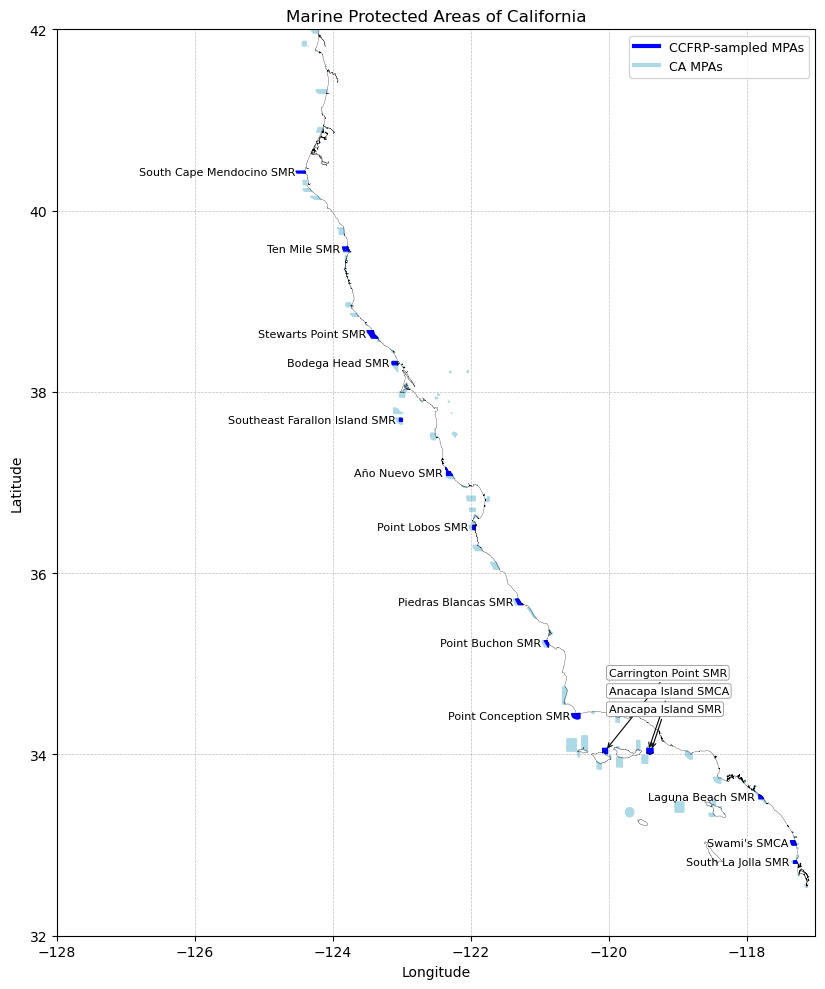

In [4]:
fig, ax = plt.subplots(figsize=(12, 10))

# Add the coastline and grid cells to the plot 
ca_mpas.plot(ax=ax, color= 'lightblue', edgecolor='lightblue', linewidth = 1)
ccfrp_mpas.plot(ax=ax, color='blue', edgecolor='blue', linewidth=1)
ca_coast.plot(ax=ax, color='black', edgecolor='black', linewidth=0.2)

# The below legend and labeling code was lifted from Chat GPT:
ax.plot([], [], color='blue', linewidth=3, label='CCFRP-sampled MPAs')
ax.plot([], [], color='lightblue', linewidth=3, label='CA MPAs')
ax.legend(loc='upper right', fontsize=9)

# For clustered MPAs, override label placement to specific lat. / long to avoid crowding 
label_overrides = {
    'Carrington Point SMR': (-120, 34.9),
    'Anacapa Island SMCA': (-120, 34.7),
    'Anacapa Island SMR': (-120, 34.5)
}

# Draw all the normal labels, excluding those that are specifically overriden 
# Iterate through rows of CCFRP MPAs shapefile attribute table 
for idx, row in ccfrp_mpas.iterrows():
    if row.geometry.is_empty:
        continue
    name = row['NAME']
    centroid = row.geometry.centroid
    # Label MPAs not included in label override directory  
    if name not in label_overrides:
        ax.text(centroid.x - 0.08, centroid.y, str(name),
                fontsize=8, ha='right', va='center', color='black')

# Then add custom annotations with arrows for crowded labels
for name, (label_x, label_y) in label_overrides.items():
    row = ccfrp_mpas[ccfrp_mpas['NAME'] == name].iloc[0]
    centroid = row.geometry.centroid
    ax.annotate(name,
                xy=(centroid.x, centroid.y),           
                xytext=(label_x, label_y),            
                textcoords='data',
                fontsize=8,
                ha='left',
                va='center',
                arrowprops=dict(arrowstyle='->', color='black', lw=0.8),
                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='gray', lw=0.5))

ax.set_title('Marine Protected Areas of California',)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.tick_params(labelsize=10)
ax.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--', alpha=0.5)
ax.set_ylim([32, 42])
ax.set_xlim([-128, -117])

plt.tight_layout()

output_path = os.path.join("Figures", "CCFRP_MPA_map.png")
plt.savefig(output_path, dpi=300)

plt.show()

## Explore & Visualize xDEM Attributes 

I import one of the digital elevation models (DEMs) to visualize some of the habitat metrics that I am going to explore in this project. Running this code also allows me to check that the xDEM package is running smoothly and that the outputs are what I might expect! The below code is adopted from the ['Terrain Attributes'](https://xdem.readthedocs.io/en/stable/basic_examples/plot_terrain_attributes.html#sphx-glr-basic-examples-plot-terrain-attributes-py) tutorial on the xDEM website. 

You will need to alter the specific path name for the raw DEM you are interested in examining to reflect where it is housed in your local computer because DEM files are too large to include in a GitHub repository. 

In [7]:
# Link to California Seafloor Mapping Program DEM that you want to run through xDEM
pigeon_point_file = '/Users/carolinedaley/Documents/MLML/MS263/Project/Data/DEM/Bathymetry_OffshorePigeonPoint.tif'
pigeon_point_DEM = xdem.DEM(pigeon_point_file)

Define which attributes you want to extract using xDEM. All attributes and their calculations can be found at the [xDEM 'Terrain attributes'](https://xdem.readthedocs.io/en/stable/terrain.html) landing page on the xDEM website. 

In [8]:
# Define the xDEm attributes you want to extract 
attributes = xdem.terrain.get_terrain_attribute(
    pigeon_point_DEM.data,
    resolution=pigeon_point_DEM.res,
    attribute=["hillshade", "slope", "aspect", "curvature", "terrain_ruggedness_index", "rugosity"],
)

Plot xDEM derived attributes for your DEM of interest! The below code is lifted from the [xDEM 'Terrain attributes'](https://xdem.readthedocs.io/en/stable/basic_examples/plot_terrain_attributes.html#sphx-glr-basic-examples-plot-terrain-attributes-py) example code gallery. 

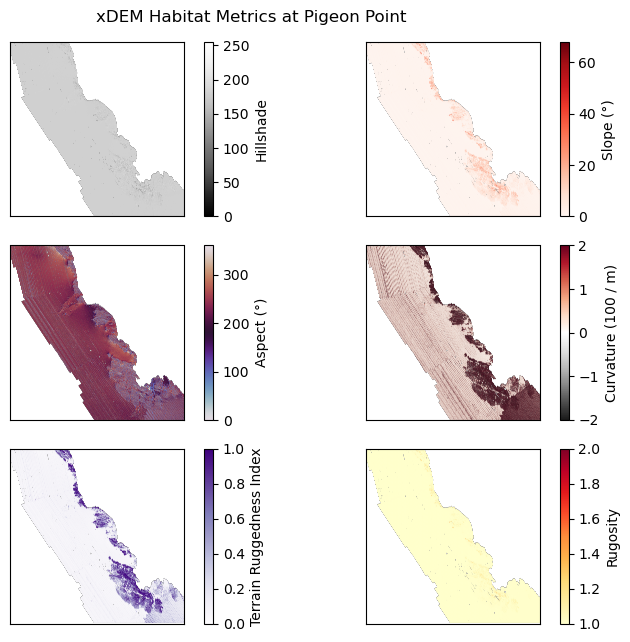

In [9]:
# This code is lifted from the xDEM 'Terrain attributes' 
plt.figure(figsize=(8, 6.5))
plt.suptitle('xDEM Habitat Metrics at Pigeon Point')

plt_extent = [pigeon_point_DEM.bounds.left, pigeon_point_DEM.bounds.right, 
              pigeon_point_DEM.bounds.bottom, pigeon_point_DEM.bounds.top]

cmaps = ["Greys_r", "Reds", "twilight", "RdGy_r", "Purples", "YlOrRd"]
labels = ["Hillshade", "Slope (°)", "Aspect (°)", "Curvature (100 / m)", "Terrain Ruggedness Index", "Rugosity"]
vlims = [(None, None) for i in range(6)]
vlims[3] = [-2, 2]
vlims[4] = [0, 1]
vlims[5] = [1, 2]

for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.imshow(attributes[i].squeeze(), cmap=cmaps[i], extent=plt_extent, vmin=vlims[i][0], vmax=vlims[i][1])
    cbar = plt.colorbar()
    cbar.set_label(labels[i])
    plt.xticks([])
    plt.yticks([])



plt.tight_layout()

output_path = os.path.join("Figures", "habitat_metrics_pigeon_point_maps.png")
plt.savefig(output_path, dpi=300)

plt.show()

## Calculate & Export Habitat Metrics

### Identify Raw DEMs 

Link to the folder where the raw DEM .tif files downloaded from the California Seafloor Mapping Program are housed. Make a list of the DEMs I will be working with. 

In [ ]:
dem_folder = "C:\\Users\\FELAB\\Documents\\MS263\\Data\\MASTER_DEM_TIFs"
dem_list = []

for file_name in os.listdir(dem_folder):
    if file_name[-4:] == '.tif':
        dem_list.append(file_name)

dem_list.sort()

print(dem_list)

### Define Output Directory 

Define the folder to export derived habitat metrics. 

In [ ]:
output_dir = "C:\\Users\\FELAB\\Documents\\MS263\\Python Repository\\xDEM_Habitat_Metrics"
os.makedirs(output_dir, exist_ok=True)

### Calculate Habitat Attributes Using xDEM

Define which habitat attributes I would like to calculate. 

In [ ]:
habitat_attributes = ["slope", "aspect", "curvature", "terrain_ruggedness_index", "rugosity"]

Calculate my specified habitat attributes for each of my DEMs of interest. The derived habitat attribtues will be exported into the above identified directory.

In [ ]:
for dem_name in dem_list:
    dem_path = os.path.join(dem_folder, dem_name)
    print(f"Calculating habitat attributes for: {dem_name}")

    dem = xdem.DEM(dem_path)

    for attribute in habitat_attributes:
        data_np = xdem.terrain.get_terrain_attribute(
            dem.data,  
            resolution=dem.res,
            attribute=attribute
        )

        # Ensure data_np has the same dtype as the original DEM data
        data_np = data_np.astype(dem.data.dtype) 

        # Create a new DEM object to hold the computed attribute
        ddem = dem.copy() 

        # Update the data of the copy with the computed terrain attribute
        ddem.data = data_np 

        # Save the computed attribute directly to a file
        out_path = os.path.join(output_dir, f"{os.path.splitext(dem_name)[0]}_{attribute}.tif")
        ddem.save(out_path)

print("Calculation complete.")

### Sanity Check
Check out the slope product that you generated! 


In [ ]:
bodega_head_slope_tif = "C:\\Users\\FELAB\\Documents\\MS263\\Python Repository\\xDEM_Habitat_Metrics\\Bathymetry_OffshorePointBuchon_slope.tif"
bodega_head_slope = xdem.DEM(bodega_head_slope_tif)

bodega_head_slope.plot(cmap="Reds", cbar_title="Slope (°)")